# Tutorial: Train and validate models
### 1. Load data and related packages
### 2. Train various models
#### 2.1 Train and tune LightGBM
#### 2.2 Visualize the results
#### 2.3 Save and load your Trainer
#### 2.4 Train other models
### 3. Cross validate models

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Load data and related packages

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

UCI Adult data are going to be used in this tutorial. The data contain both numerical and categorical features, and the target to predict is whether a person makes over 50K a year. It is a very simple binary classification task.

In [3]:
train = pd.read_csv('kuma_utils/datasets/adult_train.csv')
test = pd.read_csv('kuma_utils/datasets/adult_test.csv')

In [4]:
train.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
test.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Let's prepare the data. We need to encode categorical features.

In [7]:
from xfeat import SelectCategorical, SelectNumerical, LabelEncoder
from kuma_utils.preprocessing.xfeat import Pipeline, TargetEncoder

In [8]:
num_enc = Pipeline([
    SelectNumerical(),
])

cat_enc = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix='')
], target_col='Target')

In [9]:
train_cat, train_num = cat_enc.fit_transform(train), num_enc.fit_transform(train)
categorical_index = list(range(train_cat.shape[1]))
train_encoded = pd.concat([train_cat, train_num], axis=1) 
train_encoded.head()

,Workclass,Education,Martial_Status,Occupation,Relationship,Race,Sex,Country,Target,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week
0,0,0,0,0,0,0,0,0,0,39,77516,13,2174,0,40
1,1,0,1,1,1,0,0,0,0,50,83311,13,0,0,13
2,2,1,2,2,0,0,0,0,0,38,215646,9,0,0,40
3,2,2,1,2,1,1,0,0,0,53,234721,7,0,0,40
4,2,0,1,3,2,1,1,1,0,28,338409,13,0,0,40


Looks good to me. Let's apply the same transform to test data.

In [10]:
test_encoded = pd.concat([cat_enc.transform(test), num_enc.transform(test)], axis=1)
test_encoded.head()

,Workclass,Education,Martial_Status,Occupation,Relationship,Race,Sex,Country,Target,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week
0,2,2,0,9,3,1,0,0,0,25,226802.0,7.0,0.0,0.0,40.0
1,2,1,1,8,1,0,0,0,0,38,89814.0,9.0,0.0,0.0,50.0
2,4,6,1,11,1,0,0,0,1,28,336951.0,12.0,0.0,0.0,40.0
3,2,5,1,9,1,1,0,0,1,44,160323.0,10.0,7688.0,0.0,40.0
4,-1,5,0,-1,3,0,1,0,0,18,103497.0,10.0,0.0,0.0,30.0


In [11]:
labels, features = train_encoded['Target'], train_encoded.drop('Target', axis=1)
labels_test, features_test = test_encoded['Target'], test_encoded.drop('Target', axis=1)

## 2. Train models
Before going to training, let's define our evaluation metric. Since the task is binary classification, I will use ROC-AUC for evaluation.

In [12]:
from sklearn.metrics import roc_auc_score, make_scorer
from kuma_utils.training import Trainer, auc_metric, acc_metric

### 2.1 Make Trainer

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2)

In [14]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1
}
fit_params = {
    'num_boost_round': 500,
    'early_stopping_rounds': 50,
    'verbose_eval': 25,
}

trn = Trainer(LGBMClassifier)
trn.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    # logger='path_to_log', 
    params=params, fit_params=fit_params, 
)

Logger created at 20/11/25:09:54:42
Training until validation scores don't improve for 50 rounds
[25]	training's auc: 0.933083	valid_1's auc: 0.913392
[50]	training's auc: 0.945343	valid_1's auc: 0.919491
[75]	training's auc: 0.952456	valid_1's auc: 0.920378
[100]	training's auc: 0.957756	valid_1's auc: 0.920892
[125]	training's auc: 0.962687	valid_1's auc: 0.920059
Early stopping, best iteration is:
[99]	training's auc: 0.957504	valid_1's auc: 0.920955


In [15]:
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 99
best_score: 0.9209550889262992

In [16]:
roc_auc_score(labels_test, trn.predict_proba(features_test)[:, 1])

0.9236699584589736

In [17]:
trn = Trainer(LGBMClassifier)
trn.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    params=params, fit_params=fit_params, 
    tune_model=True, lgbm_n_trials=[5, 5, 5, 5, 5]
)

Logger created at 20/11/25:09:54:56
09:54:57 [trial    0] New best: 0.922624 
{'feature_fraction': 0.55}
09:54:58 [trial    2] New best: 0.923188 
{'feature_fraction': 0.4}
09:54:59 [trial    5] New best: 0.920451 
{'num_leaves': 140}
09:55:01 [trial    7] New best: 0.920634 
{'num_leaves': 152}
09:55:03 [trial   10] New best: 0.922425 
{'bagging_fraction': 0.6836049795069257, 'bagging_freq': 5}
09:55:04 [trial   11] New best: 0.922810 
{'bagging_fraction': 0.982310433183024, 'bagging_freq': 1}
09:55:04 [trial   12] New best: 0.923245 
{'bagging_fraction': 0.9939531560089347, 'bagging_freq': 1}
09:55:06 [trial   15] New best: 0.923245 
{'feature_fraction': 0.44000000000000006}
09:55:07 [trial   17] New best: 0.923245 
{'feature_fraction': 0.44000000000000006}
09:55:08 [trial   18] New best: 0.923245 
{'lambda_l1': 1.7120946447626043e-08, 'lambda_l2': 7.136179016363653e-06}
09:55:09 [trial   19] New best: 0.923245 
{'lambda_l1': 1.7120946447626043e-08, 'lambda_l2': 7.136179016363653e-06

In [18]:
roc_auc_score(labels_test, trn.predict_proba(features_test)[:, 1])

0.9265276055352628

In [19]:
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 104
best_score: 0.9236909467172445

### 2.2 Visualize the results

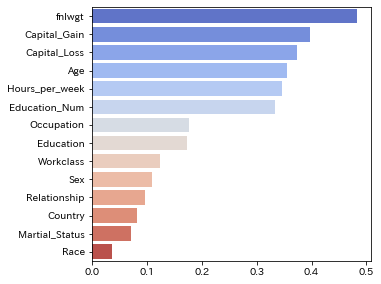

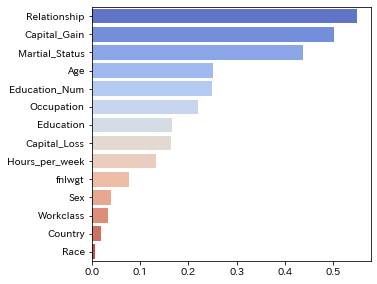

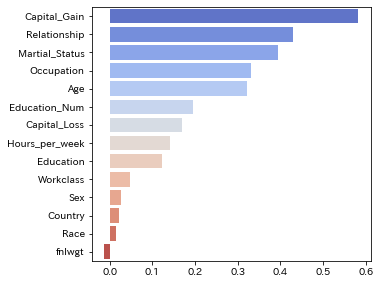

In [20]:
trn.plot_feature_importance()
trn.plot_feature_importance('gain')
trn.plot_feature_importance(
    'permutation', fit_params={
        'X': x_valid, 'y': y_valid, 'scoring': make_scorer(roc_auc_score), 'n_jobs': -1})

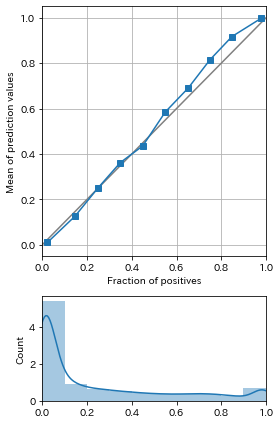

In [21]:
trn.plot_calibration_curve(data=(x_train, y_train))

### 2.3 Save and load Trainer

In [22]:
trn.save('lgbm0.trainer')
trn = Trainer(path='lgbm0.trainer')
trn

Trainer: trainer0
model: LGBMClassifier()
is_trained: True
best_iteration: 104
best_score: 0.9236909467172445

### 2.4 Train other models

In [23]:
params = {
    'objective': 'Logloss',
    'eval_metric': 'AUC',
    'iterations': 500,
    'use_best_model': True,
} 
fit_params = {
    'early_stopping_rounds': 50,
    'verbose_eval': 25
}

trn2 = Trainer(CatBoostClassifier)
trn2.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    cat_features=categorical_index,
    params=params,
    # tune_model=True, maximize=True, n_trials=5,
    fit_params=fit_params)

Logger created at 20/11/25:09:55:27
Learning rate set to 0.095841
0:	test: 0.8735575	best: 0.8735575 (0)	total: 78.7ms	remaining: 39.3s
25:	test: 0.9089744	best: 0.9089744 (25)	total: 637ms	remaining: 11.6s
50:	test: 0.9141879	best: 0.9141879 (50)	total: 1.24s	remaining: 10.9s
75:	test: 0.9173356	best: 0.9173356 (75)	total: 1.77s	remaining: 9.91s
100:	test: 0.9185100	best: 0.9185100 (100)	total: 2.29s	remaining: 9.03s
125:	test: 0.9207164	best: 0.9207164 (125)	total: 2.87s	remaining: 8.52s
150:	test: 0.9223868	best: 0.9223869 (143)	total: 3.44s	remaining: 7.95s
175:	test: 0.9229578	best: 0.9229604 (174)	total: 4.03s	remaining: 7.42s
200:	test: 0.9229776	best: 0.9231498 (187)	total: 4.58s	remaining: 6.81s
225:	test: 0.9233262	best: 0.9233262 (225)	total: 5.1s	remaining: 6.19s
250:	test: 0.9235266	best: 0.9235266 (250)	total: 5.65s	remaining: 5.61s
275:	test: 0.9235084	best: 0.9235266 (250)	total: 6.19s	remaining: 5.03s
300:	test: 0.9235210	best: 0.9235514 (287)	total: 6.75s	remaining: 4

In [24]:
roc_auc_score(labels_test, trn2.smart_predict(features_test))

0.9267138783661519

In [25]:
params = {}
fit_params = {}

trn3 = Trainer(LogisticRegression)
trn3.train(
    train_data=(x_train, y_train), 
    valid_data=(x_valid, y_valid),
    params=params,
    eval_metric=auc_metric, maximize=True,
    # tune_model=True, n_trials=5,
    fit_params=fit_params)

Logger created at 20/11/25:09:55:39
09:55:39 [None]	best score is 0.655255


In [26]:
roc_auc_score(labels_test, trn3.predict_proba(features_test)[:, 1])

0.6409081252675117

## 3. Cross validate models

In [27]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbose': -1
}
fit_params = {
    'num_boost_round': 500,
    'early_stopping_rounds': 50,
    'verbose_eval': 25,
}

trn = Trainer(LGBMClassifier)
trn.cv(
    data=(features, labels), 
    cat_features=categorical_index,
    folds=StratifiedKFold(n_splits=5), 
    params=params, fit_params=fit_params, 
)

Logger created at 20/11/25:09:55:46
[25]	cv_agg's auc: 0.919932 + 0.00349363
[50]	cv_agg's auc: 0.9252 + 0.00314706
[75]	cv_agg's auc: 0.925487 + 0.00289121
[100]	cv_agg's auc: 0.925613 + 0.00290994
[125]	cv_agg's auc: 0.925751 + 0.00310033
[150]	cv_agg's auc: 0.925324 + 0.00304159
[175]	cv_agg's auc: 0.925018 + 0.00301846
09:55:48 [125]	best score is 0.925751


In [28]:
trn

Trainer: trainer0
model: [LGBMClassifier(), LGBMClassifier(), LGBMClassifier(), LGBMClassifier(), LGBMClassifier()]
is_trained: True
best_iteration: 125
best_score: 0.9257509869339163

In [29]:
roc_auc_score(labels_test, np.stack(trn.smart_predict(features_test)).mean(0))

0.9264433713657352

**Note that Trainer.cv() is cross validation during training process.** The model is fit to the whole data rather than each fold. This returns models with same hyperparameters, but trained on different data.

In [30]:
from kuma_utils.training import CrossValidator

In [31]:
validator = CrossValidator(LGBMClassifier)
validator.train(
    data=(features, labels), params=params, fit_params=fit_params,
    folds=StratifiedKFold(n_splits=5)
)

Logger created at 20/11/25:09:56:08
09:56:08 [cv0] Starting fold 0
09:56:09 [cv0] Fold 0: eval=0.926061 (iter=127)
09:56:09 [cv0] Starting fold 1
09:56:09 [cv0] Fold 1: eval=0.925534 (iter=134)
09:56:09 [cv0] Starting fold 2
09:56:10 [cv0] Fold 2: eval=0.929985 (iter=89)
09:56:10 [cv0] Starting fold 3
09:56:10 [cv0] Fold 3: eval=0.929366 (iter=151)
09:56:10 [cv0] Starting fold 4
09:56:11 [cv0] Fold 4: eval=0.929537 (iter=122)
09:56:11 [cv0] Overall metric: 0.928097 + 0.001896


In [32]:
validator

CrossValidator: cv0
models: [Trainer: cv0_fold0
model: LGBMClassifier()
is_trained: True
best_iteration: 127
best_score: 0.9260606620794066
, Trainer: cv0_fold1
model: LGBMClassifier()
is_trained: True
best_iteration: 134
best_score: 0.9255337716093719
, Trainer: cv0_fold2
model: LGBMClassifier()
is_trained: True
best_iteration: 89
best_score: 0.9299845772653722
, Trainer: cv0_fold3
model: LGBMClassifier()
is_trained: True
best_iteration: 151
best_score: 0.9293663005250644
, Trainer: cv0_fold4
model: LGBMClassifier()
is_trained: True
best_iteration: 122
best_score: 0.929537284422264
]
is_trained: True
best_score: [0.9280965191802958, 0.00189553695432855]

In [33]:
roc_auc_score(labels_test, np.stack(validator.smart_predict(features_test)).mean(0))

0.9272003915942726

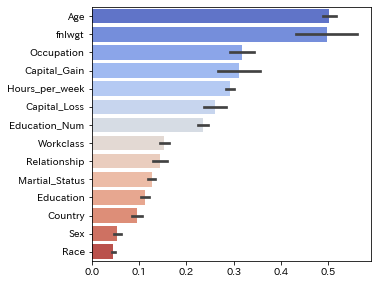

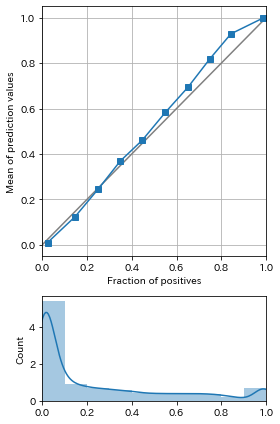

In [35]:
validator.plot_feature_importance(),
validator.plot_calibration_curve(data=(features, labels))

This one is an intuitive cross validation, in which models are fit to each fold.